# Lab 5: Google Speech Commands

## Imports

In [177]:
import copy
import wave
import os
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, AvgPool1D, MaxPool1D, ZeroPadding1D, BatchNormalization, Flatten, Dense, Activation, Dropout
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical

## Create the testing List

In [178]:
dataset_dir = Path('dataset')
END_LETTER = 'G'
END_NUMBER = 15

with open(dataset_dir/'testing_list.txt', 'w') as f:
    for letter in range(ord('A'), ord(END_LETTER)+1):
        for number in range(END_NUMBER+1):
            f.write('{}/{}_{:d}.wav\n'.format( chr(letter), chr(letter), number))


## Load raw spoken digits data from Google Speech Commands

In [179]:
# Classes to handle, ordered by label

# get a list of all directories in the directory
CLASSES = [name for name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, name))]
print(CLASSES)
# not needed in this section, but to know the number of them when we do the dense layers (output)

with (dataset_dir/'testing_list.txt').open() as f:
    testing_list = f.read().splitlines()

#print(testing_list)
x_train = []
y_train = []
x_test = []
y_test = []

for recording in dataset_dir.glob(f'**/*.wav'):
    #if not recording.parent.name in CLASSES: # Ignore unused classes
    #    continue
    label = CLASSES.index(recording.parent.name) # Assign class number
    
    with wave.open(str(recording)) as f: # Read wave file
        data = np.frombuffer(f.readframes(f.getnframes()), dtype=np.int16).copy() # As 16-bit signed integer
        
    data = data.astype(np.float32) # Convert to 32-bit floating-point
    data.resize((16000, 1)) # Resize to 1s (16kHz) with zero-padding, 1 channel
    #print(str(recording.relative_to(dataset_dir)))
    if str(recording.relative_to(dataset_dir)).replace("\\","/") in testing_list: # Assign to test set if file in test list
        
        x_test.append(data)
        y_test.append(label)
    else:
        x_train.append(data)
        y_train.append(label)

x_train = np.array(x_train)
y_train = to_categorical(np.array(y_train))
x_test = np.array(x_test)
y_test = to_categorical(np.array(y_test))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


## Prepare for inference with fixed-point Q7.9 samples by scaling input data accordingly

In [180]:
FIXED_POINT = 9
x_train /= 2**FIXED_POINT
x_test  /= 2**FIXED_POINT

## Export small dataset

In [181]:
perms = np.random.permutation(len(y_test))[0:40]
x_test_small = x_test[perms]
y_test_small = y_test[perms]
np.savetxt('x_test_small.csv', x_test_small.reshape((x_test_small.shape[0], -1)), delimiter=',', fmt='%s')
np.savetxt('y_test_small.csv', y_test_small, delimiter=',', fmt='%s')

## Build model M5

In [195]:

model = Sequential()
model.add(Input(shape=(16000, 1)))
# under 120kB of data flow, (ram), 1MB flash
model.add(MaxPool1D(pool_size=2)) 
model.add(Conv1D(filters=16, kernel_size=20, strides = 8, activation='relu'))
model.add(MaxPool1D(pool_size=2)) 
model.add(Conv1D(filters=32, kernel_size=3, strides = 2, activation='relu'))
model.add(MaxPool1D(pool_size=2)) 
model.add(Conv1D(filters=64, kernel_size=3, strides = 2, activation='relu'))
model.add(MaxPool1D(pool_size=2)) 
model.add(Conv1D(filters=128, kernel_size=3, strides = 1, activation='relu'))
model.add(MaxPool1D(pool_size=2)) 

model.summary() #we were checking here in order to get the infos about how to avgPool
model.add(AvgPool1D(pool_size=14)) #squeeze the temporal dimensions on 1 to only have the filters
model.add(Flatten())
model.add(Dense(units=40))
model.add(Dense(units=len(CLASSES)))
model.add(Activation('softmax')) # SoftMax activation needs to be separate from Dense to remove it later on

# EXPLORE Learning Rate
opt = tf.keras.optimizers.Adam(learning_rate=10e-5)
#model.summary()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])




Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling1d_145 (MaxPooli  (None, 8000, 1)          0         
 ng1D)                                                           
                                                                 
 conv1d_116 (Conv1D)         (None, 998, 16)           336       
                                                                 
 max_pooling1d_146 (MaxPooli  (None, 499, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_117 (Conv1D)         (None, 249, 32)           1568      
                                                                 
 max_pooling1d_147 (MaxPooli  (None, 124, 32)          0         
 ng1D)                                                           
                                                     

## Train model

Epoch 1/25
193/193 [==============================] - 3s 9ms/step - loss: 1.8336 - categorical_accuracy: 0.2571 - val_loss: 1.6528 - val_categorical_accuracy: 0.3036
Epoch 2/25
193/193 [==============================] - 1s 7ms/step - loss: 1.5298 - categorical_accuracy: 0.4364 - val_loss: 1.3927 - val_categorical_accuracy: 0.5893
Epoch 3/25
193/193 [==============================] - 1s 7ms/step - loss: 1.2745 - categorical_accuracy: 0.5870 - val_loss: 1.2303 - val_categorical_accuracy: 0.5536
Epoch 4/25
193/193 [==============================] - 1s 7ms/step - loss: 1.0915 - categorical_accuracy: 0.6390 - val_loss: 1.1076 - val_categorical_accuracy: 0.5625
Epoch 5/25
193/193 [==============================] - 1s 7ms/step - loss: 0.9321 - categorical_accuracy: 0.6779 - val_loss: 0.9328 - val_categorical_accuracy: 0.6696
Epoch 6/25
193/193 [==============================] - 1s 7ms/step - loss: 0.8188 - categorical_accuracy: 0.7351 - val_loss: 0.8655 - val_categorical_accuracy: 0.6964
Epoc

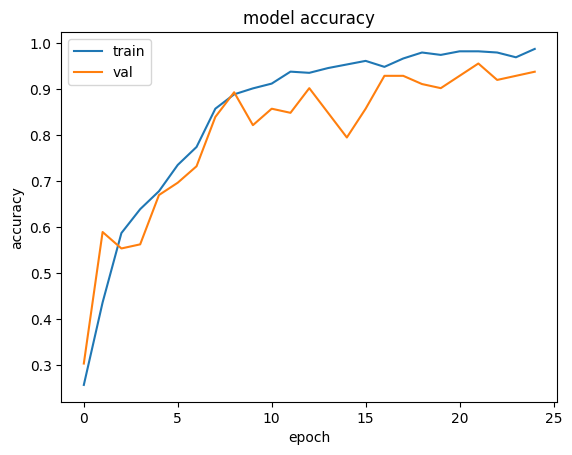

In [196]:
history = model.fit(x_train, y_train, epochs=25, batch_size=2, validation_data=(x_test, y_test)) 
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate model on test dataset

4/4 - 0s - loss: 0.2505 - categorical_accuracy: 0.9375 - 80ms/epoch - 20ms/step
4/4 [==============================] - 0s 8ms/step


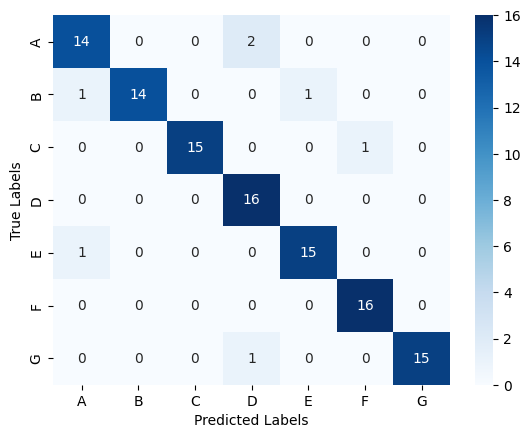

In [199]:
"""
model.evaluate(x_test, y_test, verbose=2)
pred_test = model.predict(x_test)
print(tf.math.confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1)))
"""
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
model.evaluate(x_test, y_test, verbose=2)

# Predict the classes for the test data
pred_test = model.predict(x_test)

# Create the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion_matrix, annot=True, xticklabels=CLASSES, yticklabels=CLASSES,cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Evaluate model on small dataset

In [200]:
model.evaluate(x_test_small, y_test_small, verbose=2)
pred_test_small = model.predict(x_test_small)
print(tf.math.confusion_matrix(y_test_small.argmax(axis=1), pred_test_small.argmax(axis=1)))

2/2 - 0s - loss: 0.2703 - categorical_accuracy: 0.9250 - 48ms/epoch - 24ms/step
2/2 [==============================] - 0s 16ms/step
tf.Tensor(
[[7 0 0 1 0 0 0]
 [0 6 0 0 0 0 0]
 [0 0 5 0 0 1 0]
 [0 0 0 4 0 0 0]
 [1 0 0 0 4 0 0]
 [0 0 0 0 0 7 0]
 [0 0 0 0 0 0 4]], shape=(7, 7), dtype=int32)


## Save trained model

In [201]:
model.save('lab_gsc.h5')

## Remove SoftMax layer

In [202]:
model = tf.keras.Model(model.input, model.layers[-2].output, name=model.name)

## Install MicroAI for C inference code generation (kerascnn2c module)

In [203]:
%pip install https://bitbucket.org/edge-team-leat/microai_public/get/6adfbcb347d3.zip#subdirectory=third_party/kerascnn2c_fixed
import kerascnn2c

     ---------------------------------------- 1.9/1.9 MB 889.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Generate C code for the trained model with 16-bit fixed-point representation

In [204]:
res = kerascnn2c.Converter(output_path=Path('gsc_output_fixed'),
                           fixed_point=FIXED_POINT, # Number of bits for the fractional part, Q7.9 format
                           number_type='int16_t', # Data type for weights/activations (16 bits quantization)
                           long_number_type='int32_t', # Data type for intermediate results
                           number_min=-(2**15), # Minimum value for 16-bit signed integers
                           number_max=(2**15)-1 # Maximum value for 16-bit signed integers
                          ).convert_model(model)
with open('ukulele_model_fixed2.h', 'w') as f:
    f.write(res)

———————————————————————————————————————————————————————————————————————————————————————————————————————
Inputs                           | Layer                            | Outputs                         
———————————————————————————————————————————————————————————————————————————————————————————————————————
                                 | input_30                         | max_pooling1d_145               
-------------------------------------------------------------------------------------------------------
input_30                         | max_pooling1d_145                | conv1d_116                      
-------------------------------------------------------------------------------------------------------
max_pooling1d_145                | conv1d_116                       | max_pooling1d_146               
-------------------------------------------------------------------------------------------------------
conv1d_116                       | max_pooling1d_146                

## Compile the 16-bit fixed-point C code for x86 and evaluate on small dataset

In [205]:
!g++ -Wall -Wextra -pedantic -Ofast -o gsc_fixed -Igsc_output_fixed/ gsc_output_fixed/model.c main.cpp 
!gsc_fixed x_test_small.csv y_test_small.csv

#test on the entire dataset

gsc_output_fixed/model.c: In function 'void cnn(const number_t (*)[16000], number_t*)':
gsc_output_fixed/model.c:162:18: warning: left operand of comma operator has no effect [-Wunused-value]
  162 |     activations2.average_pooling1d_29_output,
      |     ~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing accuracy: 0.95
